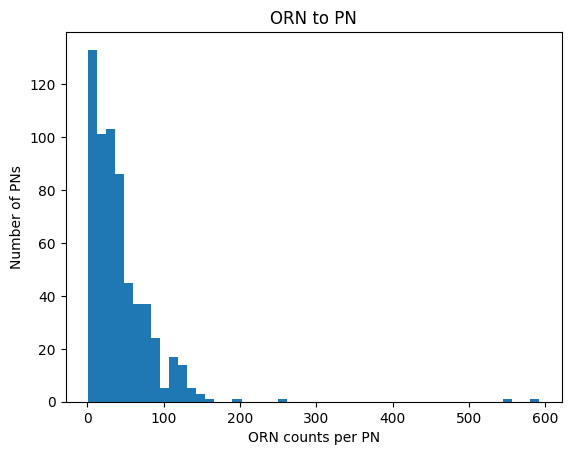

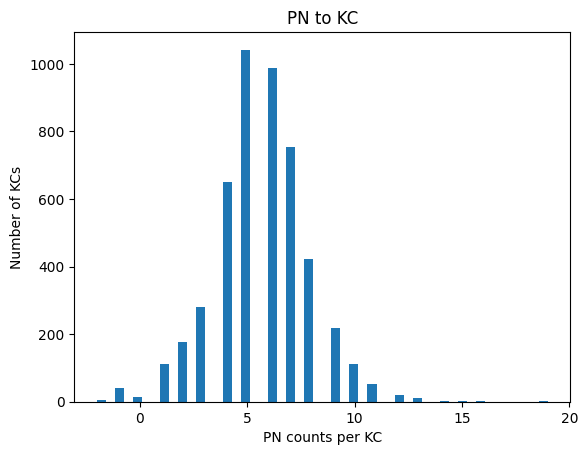

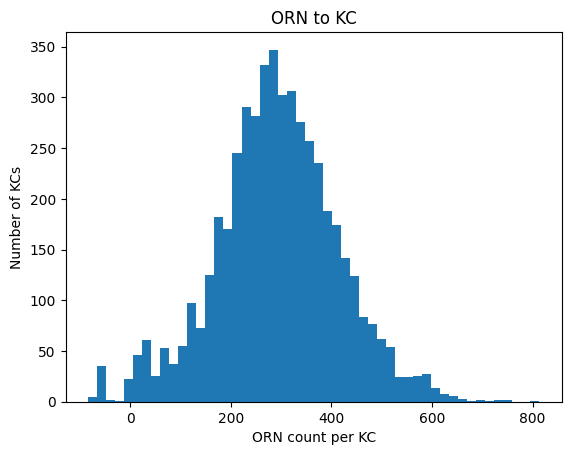

torch.Size([4907, 2278])


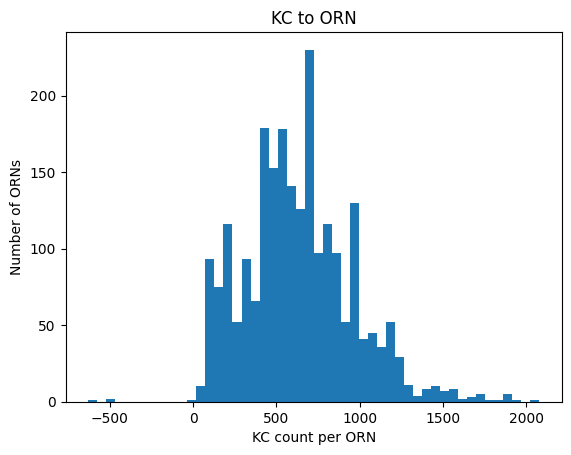

In [3]:
#------------Import Data---------------
csv_path_cnt= ('Connectome.csv')
cntset = pd.read_csv(csv_path_cnt)
csv_path_ann= ('DoOR.csv')
X_ann = pd.read_csv(csv_path_ann)

ff=cntset[cntset["directionality"]=='feedforward']
otp=ff[(ff["pre_class"]=='ORN') & (ff["post_class"]=='ALPN')]
ptk=ff[(ff['pre_class']=='ALPN') & (ff['post_class']=='KC')]

#-----------ORN to ALPN mask: 'mask_otp'-----------------
otp_unique = otp[['pre_root_id','post_root_id']]
mask_otp_norm = pd.crosstab(
    index=otp_unique['pre_root_id'],    # Row: ORN ID
    columns=otp_unique['post_root_id']  # Column: ALPN ID
    , values=otp['syn_count']           # syn count
    , aggfunc='sum'
    ).fillna(0)                         #NaN = 0

mask_otp = torch.from_numpy(mask_otp_norm.T.values).float().to(device)  # (615, 2278)

#------------ALPN to KC mask: 'mask_ptk'-----------------
alpn_ids=mask_otp_norm.columns

ptk_unique=ptk[['pre_root_id', 'post_root_id']]
mask_ptk_norm = (
    pd.crosstab(
        index=ptk_unique['pre_root_id'],    # Row: ALPN ID
        columns=ptk_unique['post_root_id'], # Column: KC ID
        values=ptk['syn_count'],
        aggfunc='sum'
    )
    .reindex(index=alpn_ids,   # Make ALPN ID 615
             fill_value=0)
    .fillna(0)                 # NaN = 0
)
mask_ptk = torch.from_numpy(mask_ptk_norm.T.values).float().to(device)  # (4907,334)


#-----------------------------------------
otp_T=mask_otp.T
ptk_T=mask_ptk.T

otk = otp_T @ ptk_T # Use @ for matrix multiplication

#----------ORN to ALPN----------
so= otp_T.sum(axis=0).cpu()
otp_s=torch.sign(otp_T)
sos=otp_s.sum(axis=0).cpu()
plt.figure()
plt.hist(sos, bins=50)
plt.xlabel('ORN counts per PN')
plt.ylabel('Number of PNs')
plt.title('ORN to PN')
plt.show()

#----------ALPN to KC-----------
sp= ptk_T.sum(axis=0).cpu()
ptk_s=torch.sign(ptk_T)
sps=ptk_s.sum(axis=0).cpu()

plt.figure()
plt.hist(sps, bins=50)
plt.xlabel('PN counts per KC')
plt.ylabel('Number of KCs')
plt.title('PN to KC')
plt.show()

#-----------ORN to KC-----------
sk=otk.sum(axis=0).cpu()
otk_s=torch.sign(otk)
sks=otk_s.sum(axis=0).cpu()
plt.figure()
plt.hist(sks, bins=50)
plt.xlabel('ORN count per KC')
plt.ylabel('Number of KCs')
plt.title('ORN to KC')
plt.show()

##------------KC to ORN (from KC version)---------
kto= mask_ptk @ mask_otp
print(kto.shape)
si=kto.sum(axis=0).cpu()
ktp_s=torch.sign(kto)
sis=ktp_s.sum(axis=0).cpu()

plt.figure()
plt.hist(sis, bins=50)
plt.xlabel('KC count per ORN')
plt.ylabel('Number of ORNs')
plt.title('KC to ORN')
plt.show()